In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [106]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Load Dataset and Train Test Val split

In [107]:
DATA_HANDLE = 'colorectal_histology'

In [108]:
from datasets import load_dataset
(train_dataset,test_dataset,val_dataset), info = tfds.load(DATA_HANDLE, with_info= True, split=['train[:80%]','train[80%:90%]','train[90%:]'], as_supervised=True)
info

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_path='/home/bdurand/tensorflow_datasets/colorectal_histology/2.0.0',
    file_format=tfrecord,
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikol

# Explore

2022-12-17 03:00:06.923550: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


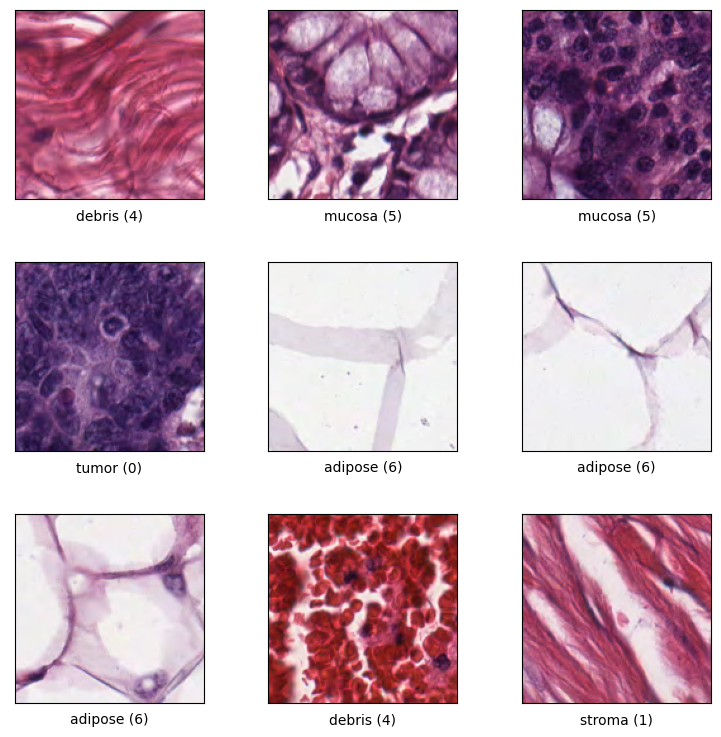

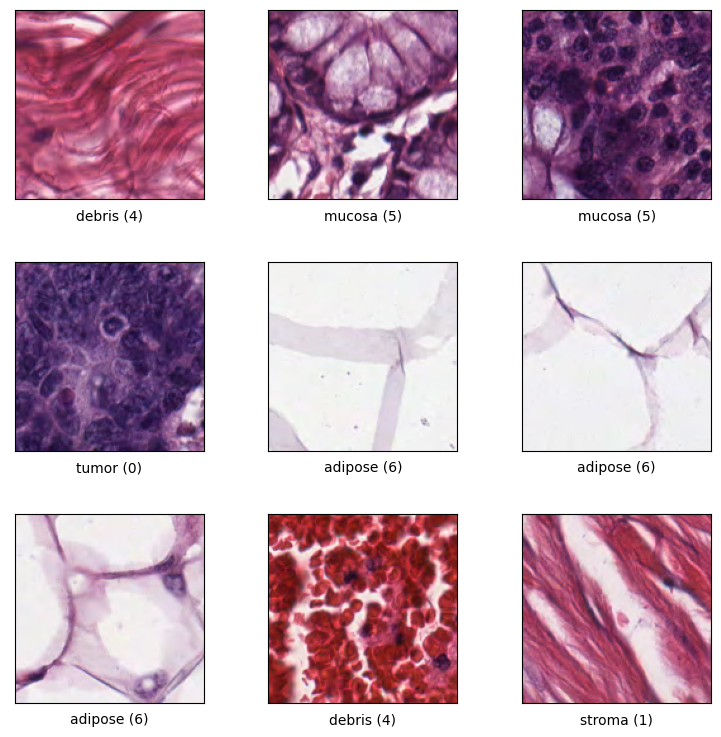

In [109]:
tfds.visualization.show_examples(train_dataset, info)

In [110]:
train_df = tfds.as_dataframe(train_dataset,info)
test_df = tfds.as_dataframe(test_dataset,info)
val_df = tfds.as_dataframe(val_dataset,info)

In [111]:
train_df.head()

,image,label
0,"[[[173, 82, 113], [186, 95, 126], [213, 98, 13...",4
1,"[[[106, 47, 87], [128, 69, 109], [135, 72, 114...",5
2,"[[[118, 51, 102], [122, 55, 106], [120, 48, 98...",5
3,"[[[100, 60, 121], [108, 66, 122], [109, 67, 12...",0
4,"[[[241, 243, 240], [241, 243, 240], [241, 243,...",6


# Rescaling and Resizing

In [112]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [113]:
image = train_df['image'][7]
result = resize_and_rescale(image)
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.011764707 1.0


In [114]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

# Implementing first model

In [128]:
num_classes = 8

model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [129]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [130]:
LOG_DIR = 'colorectal_logs'

def best_model_path(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    return os.path.join(base_dir, 'best_val_accuracy.ckpt')

def callback_list(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    tb_cb = tf.keras.callbacks.TensorBoard(base_dir)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
         best_model_path(model_name),
         monitor='val_accuracy',
         mode='max', 
         verbose=0,
         save_best_only=True)
    backup_dir = os.path.join(base_dir, 'backup_checkpoint')
    bkp = tf.keras.callbacks.BackupAndRestore(
        backup_dir)
    return [tb_cb, ckpt, bkp]


In [131]:
epochs=5
logs = {}

logs['Model 1'] = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=callback_list('Model 1')
)

Epoch 1/5
125/125 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.5378

INFO:tensorflow:Assets written to: colorectal_logs/Model 1/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: colorectal_logs/Model 1/best_val_accuracy.ckpt/assets


125/125 [==============================] - 13s 97ms/step - loss: 1.0771 - accuracy: 0.5378 - val_loss: 0.7728 - val_accuracy: 0.6460
Epoch 2/5
125/125 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.6980

INFO:tensorflow:Assets written to: colorectal_logs/Model 1/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: colorectal_logs/Model 1/best_val_accuracy.ckpt/assets


125/125 [==============================] - 13s 97ms/step - loss: 0.7617 - accuracy: 0.6980 - val_loss: 0.6032 - val_accuracy: 0.7460
Epoch 3/5
125/125 [==============================] - 12s 93ms/step - loss: 0.6539 - accuracy: 0.7433 - val_loss: 0.6315 - val_accuracy: 0.7140
Epoch 4/5
125/125 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.7620

INFO:tensorflow:Assets written to: colorectal_logs/Model 1/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: colorectal_logs/Model 1/best_val_accuracy.ckpt/assets


125/125 [==============================] - 13s 102ms/step - loss: 0.6239 - accuracy: 0.7620 - val_loss: 0.5051 - val_accuracy: 0.8020
Epoch 5/5
125/125 [==============================] - 13s 97ms/step - loss: 0.5501 - accuracy: 0.7883 - val_loss: 0.5368 - val_accuracy: 0.7640


In [132]:
loss, acc = model.evaluate(test_dataset)
print("Accuracy", acc)

16/16 [==============================] - 1s 39ms/step - loss: 0.5395 - accuracy: 0.7880
Accuracy 0.7879999876022339


# Data Augmentation

In [119]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [120]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

# Preprocessing function

In [121]:
batch_size = 32

def prepare(ds, shuffle=False, augment=False):

  if shuffle:
    ds = ds.shuffle(1000)
  ds = ds.batch(batch_size)
  return ds.prefetch(buffer_size=AUTOTUNE)

In [122]:
train_dataset = prepare(train_dataset, shuffle=True, augment=True)
val_dataset = prepare(val_dataset)
test_dataset = prepare(test_dataset)

# Implementing the second model

In [123]:
num_classes = 8

model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [124]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [125]:
epochs=20
logs = {}

logs['Model 2'] = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=callback_list('Model 2')
)

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 1.2546 - accuracy: 0.4762

INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


125/125 [==============================] - 13s 94ms/step - loss: 1.2546 - accuracy: 0.4762 - val_loss: 0.9069 - val_accuracy: 0.6540
Epoch 2/20
125/125 [==============================] - 12s 89ms/step - loss: 0.8926 - accuracy: 0.6105 - val_loss: 0.7852 - val_accuracy: 0.5840
Epoch 3/20
125/125 [==============================] - 12s 92ms/step - loss: 0.7666 - accuracy: 0.6895 - val_loss: 0.7870 - val_accuracy: 0.6300
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.7205

INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


125/125 [==============================] - 13s 102ms/step - loss: 0.6940 - accuracy: 0.7205 - val_loss: 0.5746 - val_accuracy: 0.7500
Epoch 5/20
125/125 [==============================] - 13s 100ms/step - loss: 0.6051 - accuracy: 0.7690 - val_loss: 0.6763 - val_accuracy: 0.6960
Epoch 6/20
125/125 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.7405

INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


125/125 [==============================] - 14s 109ms/step - loss: 0.6483 - accuracy: 0.7405 - val_loss: 0.6113 - val_accuracy: 0.7900
Epoch 7/20
125/125 [==============================] - 14s 105ms/step - loss: 0.5971 - accuracy: 0.7663 - val_loss: 0.5654 - val_accuracy: 0.7580
Epoch 8/20
125/125 [==============================] - 13s 99ms/step - loss: 0.5272 - accuracy: 0.7985 - val_loss: 0.6774 - val_accuracy: 0.7080
Epoch 9/20
125/125 [==============================] - 13s 99ms/step - loss: 0.5583 - accuracy: 0.7760 - val_loss: 0.6134 - val_accuracy: 0.7400
Epoch 10/20
125/125 [==============================] - 13s 97ms/step - loss: 0.5043 - accuracy: 0.8105 - val_loss: 0.5888 - val_accuracy: 0.7600
Epoch 11/20
125/125 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.8248

INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


125/125 [==============================] - 13s 103ms/step - loss: 0.4596 - accuracy: 0.8248 - val_loss: 0.4613 - val_accuracy: 0.8260
Epoch 12/20
125/125 [==============================] - 13s 98ms/step - loss: 0.4662 - accuracy: 0.8240 - val_loss: 0.4780 - val_accuracy: 0.8220
Epoch 13/20
125/125 [==============================] - 15s 115ms/step - loss: 0.4418 - accuracy: 0.8370 - val_loss: 0.4330 - val_accuracy: 0.8240
Epoch 14/20
125/125 [==============================] - 20s 150ms/step - loss: 0.4657 - accuracy: 0.8213 - val_loss: 0.5561 - val_accuracy: 0.7960
Epoch 15/20
125/125 [==============================] - 22s 170ms/step - loss: 0.4576 - accuracy: 0.8257 - val_loss: 0.4461 - val_accuracy: 0.8240
Epoch 16/20
125/125 [==============================] - 13s 101ms/step - loss: 0.4269 - accuracy: 0.8432 - val_loss: 0.4795 - val_accuracy: 0.8000
Epoch 17/20
125/125 [==============================] - 12s 94ms/step - loss: 0.4579 - accuracy: 0.8255 - val_loss: 0.4724 - val_accuracy:

INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: colorectal_logs/Model 2/best_val_accuracy.ckpt/assets


125/125 [==============================] - 14s 104ms/step - loss: 0.4224 - accuracy: 0.8468 - val_loss: 0.3759 - val_accuracy: 0.8660
Epoch 19/20
125/125 [==============================] - 13s 98ms/step - loss: 0.4037 - accuracy: 0.8505 - val_loss: 0.4356 - val_accuracy: 0.8540
Epoch 20/20
125/125 [==============================] - 13s 99ms/step - loss: 0.3606 - accuracy: 0.8618 - val_loss: 0.3702 - val_accuracy: 0.8620


In [126]:
loss, acc = model.evaluate(test_dataset)
print("Accuracy", acc)

16/16 [==============================] - 1s 38ms/step - loss: 0.4310 - accuracy: 0.8380
Accuracy 0.8379999995231628


In [133]:
%tensorboard --logdir ./colorectal_logs

Reusing TensorBoard on port 6006 (pid 28321), started 0:29:04 ago. (Use '!kill 28321' to kill it.)